# Practicum II - Movie Database Applicaton
### Collaborators: Abasamia Akpan, Rebecca Brent and Alessia Pizzoccheri

This Notebook provides context, documentation and sample code for a Database Application using IMBd datasets; for clarity, this document has been divided into the following sections:

### 1. Schemas and Models
### 2. Parsing and Importing the Data
### 3. Defining Queries
### 4. Database and Relations Definition¶
----
### 1. Schemas and Models

#### 1.1. Looking at the data
In this section, we analyze and deconstruct the various data sets found on the IMBd page; data is organized in seven TSV files, specifically:
1. Title AKAs
2. Title Basics
3. Title Episodes
4. Title Ratings
5. Title Crew
6. Name Basics
7. Title Principles 

For semplicity, some of the tables mentioned above will not be part of our model and schema. 

Our first step is to establish relationships between each data set and identify a primary key (PK) on each table. Since no information was provided regarding the role of each column, we devised a solution to find unique identifiers within each data set; that is, for each table we compare the total number of rows against the total number of unique values for a given column.

#### 1.2 Logical Model and Relational Schema
Following the previously mentioned method, we identified the following relational schema and logical model.

TITLE_BASICS(<u>t_const</u>,genres, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_mins);

NAME_BASICS(<u>n_const</u>, known_for_titles, primary_name, birth_year, death_year, primary_profession);

TITLE_RATINGS(<u>t_const</u>, num_votes, average_rating);

TITLE_EPISODES(<u>t_const</u>, season_num, eposiode_num, parent_t_const);


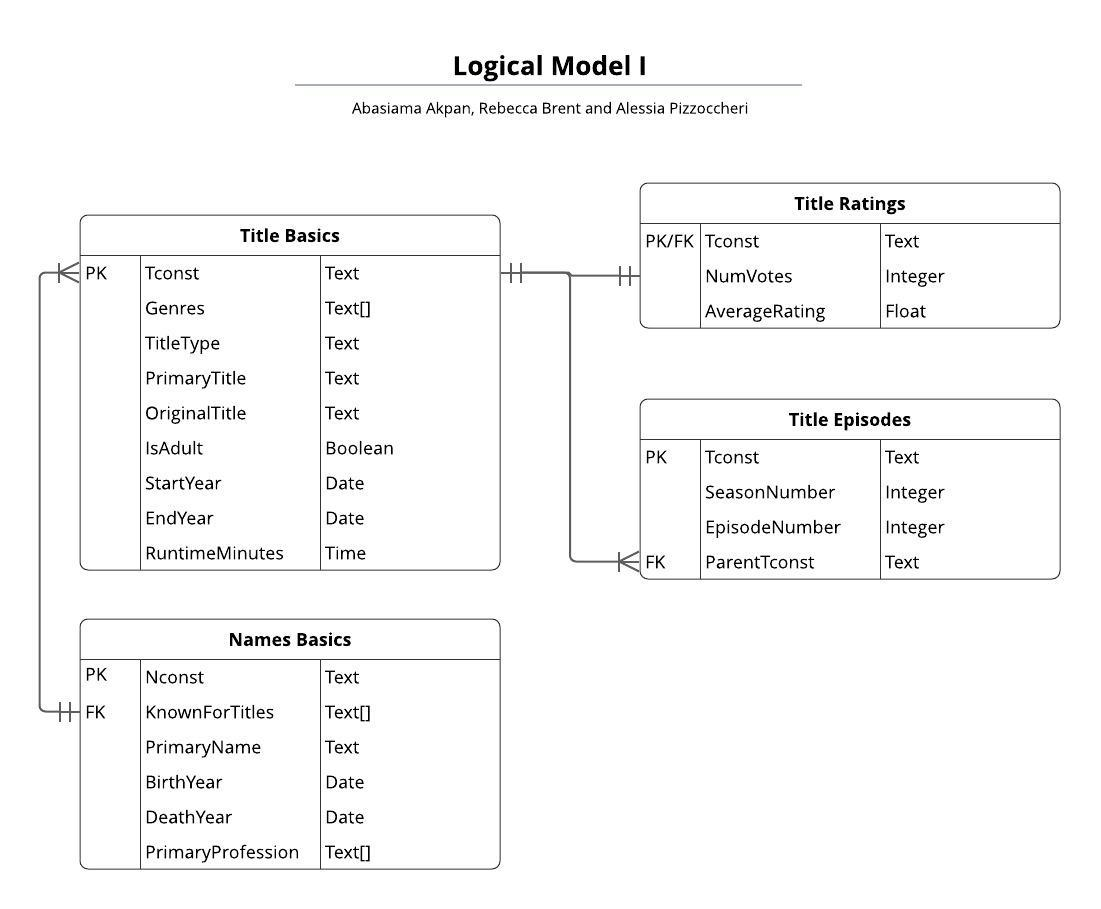

#### 1.3 Refactoring the Model and Schema
Our next step is to remove and refactor the schema and model to eliminate any _many-to-many_ relationships; the new model and schema are presented below.

TITLE_BASICS(<u>t_const</u>, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_mins); 

NAME_BASICS(<u>n_const</u>, primary_name, birth_year, death_year, primary_profession);

TITLE_RATINGS(<u>t_const</u>, num_votes, average_rating);

TITLE_EPISODES(<u>t_const</u>, season_num, eposiode_num, parent_t_const);

TITLE_GENRES(<u>title_basics_id</u>, <u>genre_id</u>)

GENRES(<u>genre_id</u>, name)

KNOWN_FOR_TITLES(<u>name_basics_id</u>, <u>known_for_titles</u>)

NAME_PRIMARY_PROFESSION(<u>primary_profession_id</u>, <u>name_basics_id</u>)

PRIMARY_PROFESSION(<u>primary_profession_id</u>, name)


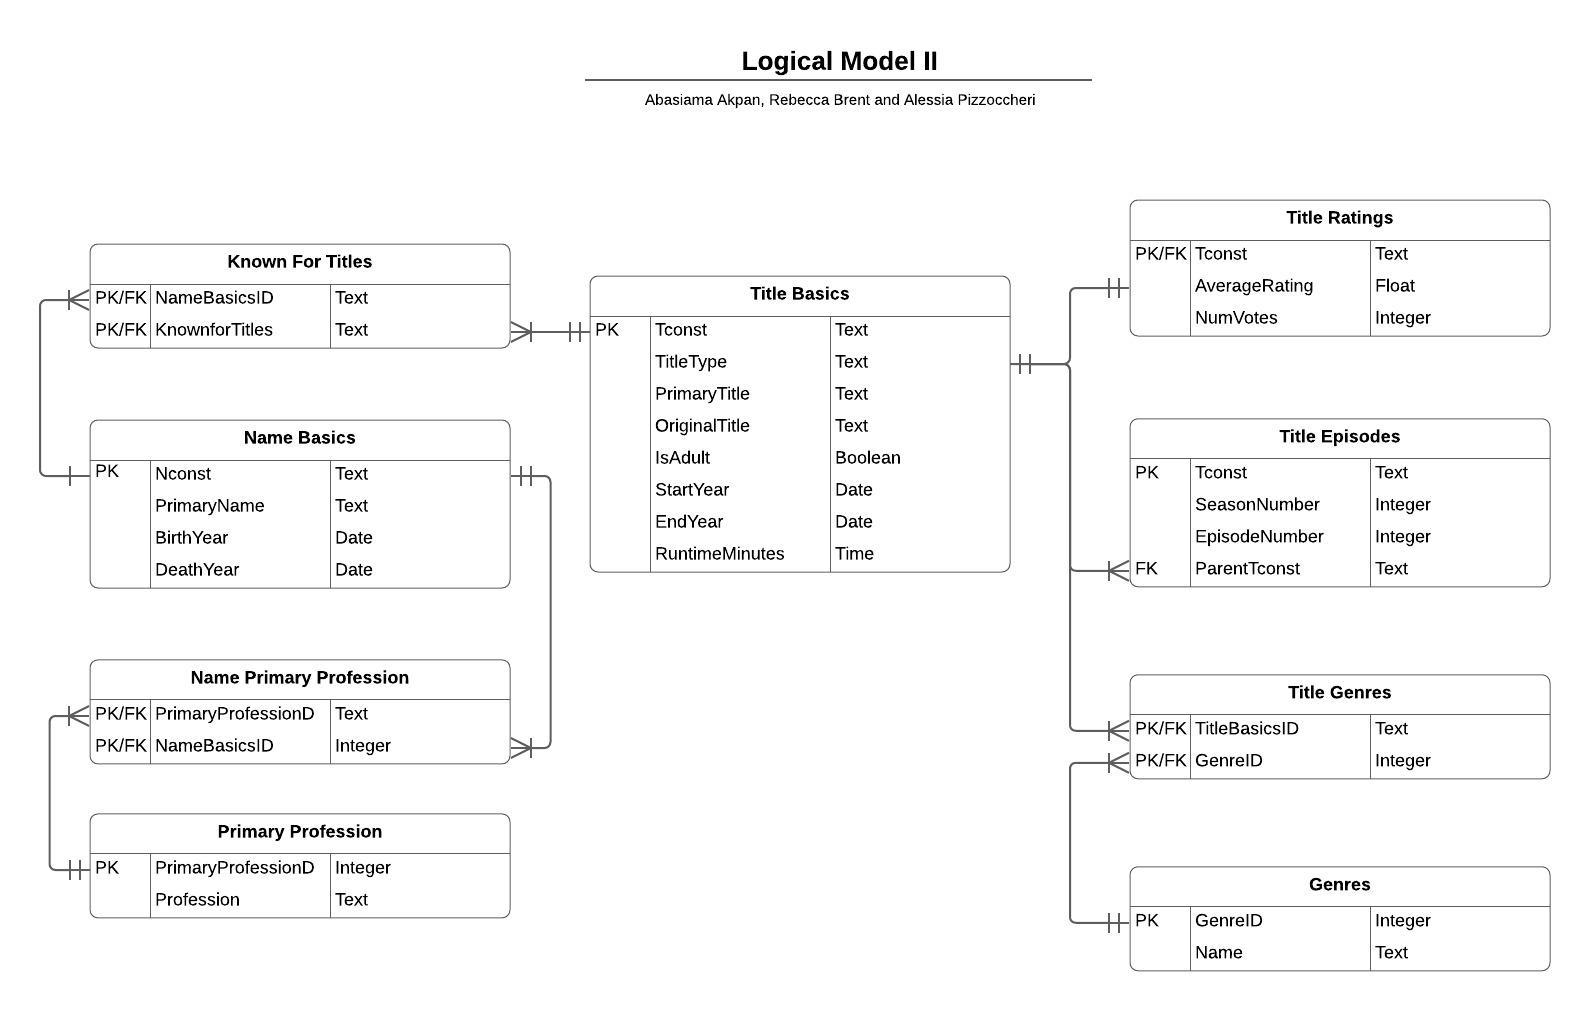

#### 1.3 Updating the Model and Schema with additional columns
Finally, we update our model and schema by adding two additional columns to our _NAME_BASICS_ table; specifically, we included two columns: 

TITLE_BASICS(<u>t_const</u>, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_mins); 

NAME_BASICS(<u>n_const</u>, primary_name, birth_year, death_year, age, no_of_movies);

TITLE_RATINGS(<u>t_const</u>, num_votes, average_rating);

TITLE_EPISODES(<u>t_const</u>, season_num, episode_num, parent_t_const);

TITLE_GENRES(<u>title_basics_id</u>, <u>genre_id</u>)

GENRES(<u>genre_id</u>, name)

KNOWN_FOR_TITLES(<u>name_basics_id</u>, <u>known_for_titles</u>)

NAME_PRIMARY_PROFESSION(<u>primary_profession_id</u>, <u>name_basics_id</u>)

PRIMARY_PROFESSION(<u>primary_profession_id</u>, name)


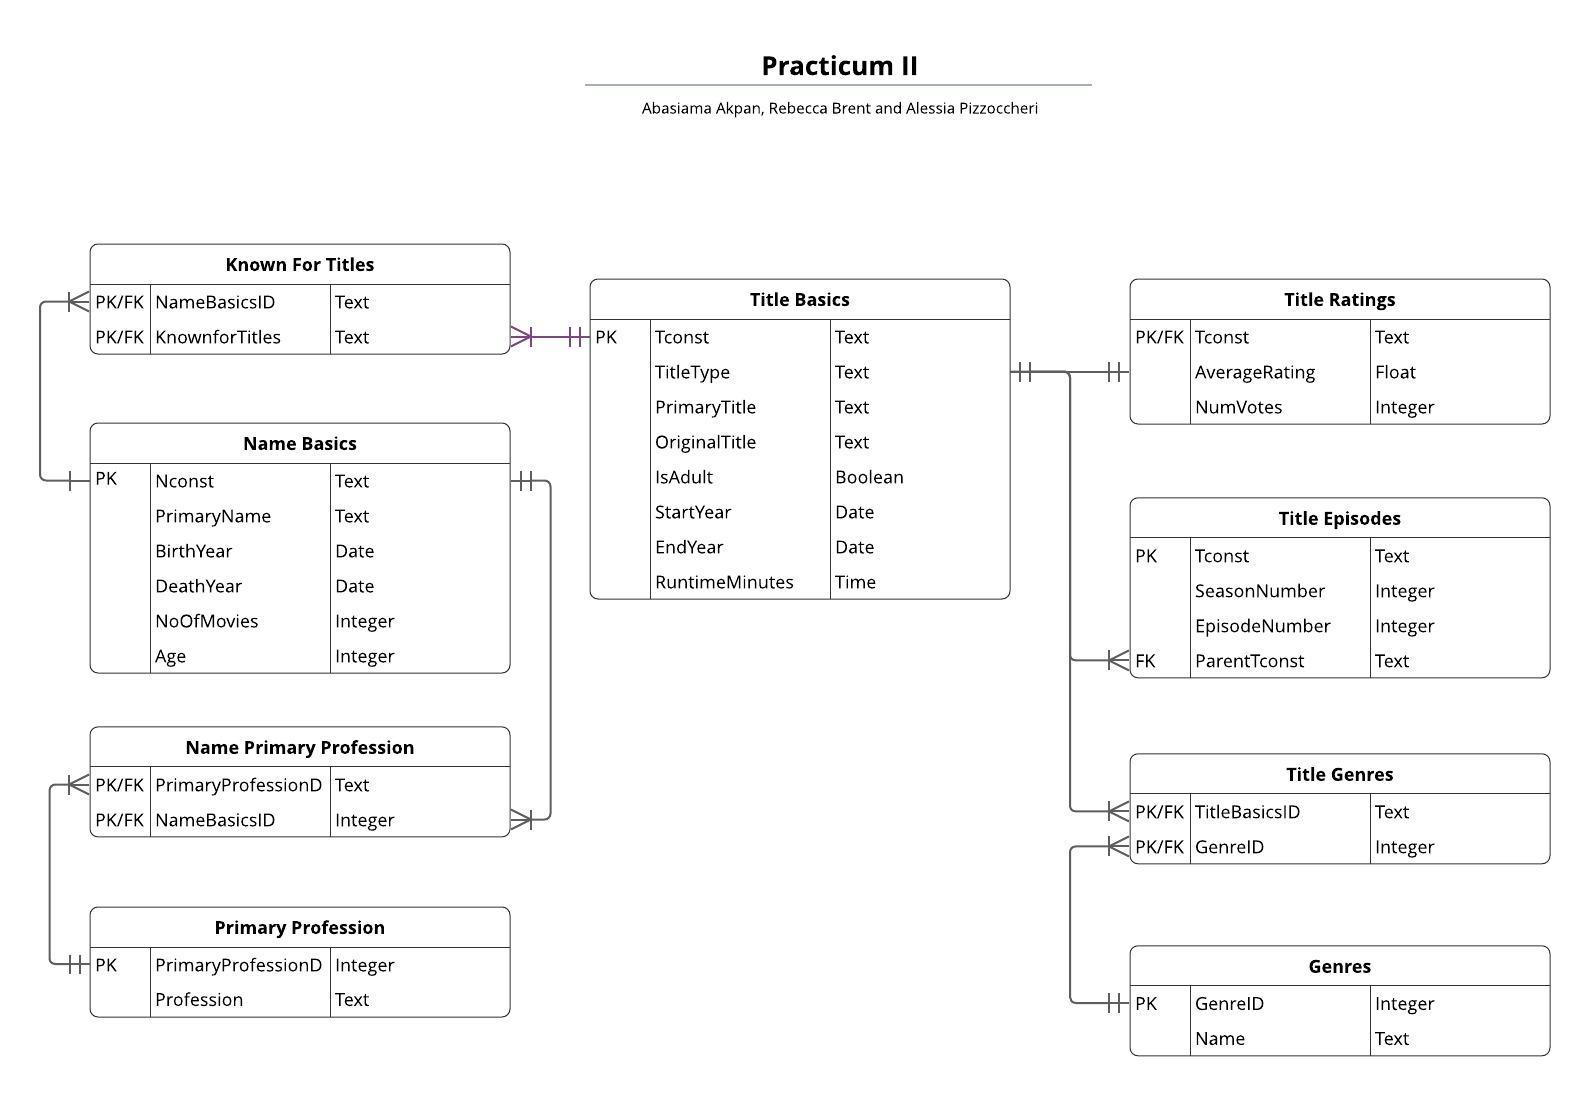

### 2. Parsing and Importing the Data
#### 2.1 Installing libraries and creating the database
In the following section, we create the database, create the tables and add them to the database; to help with our task, we import a handful of libraries.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import pip

from tqdm import tqdm
import mysql.connector
from mysql.connector import Error

# install packages used below if not already installed -- not necessary to run this chunk if they are
pip.main(['install','prettytable'])
pip.main(['install','mysql-connector-python'])
pip.main(['install','tqdm'])
pip.main(['install','pymysql'])
pip.main(['install', 'tkinter'])

host_name = "localhost"
user_name = "root"
database = "imdb"
password = input("Please enter the password for connecting to SQL (root): ")

BATCH_SIZE = 10000

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


Please enter the password for connecting to SQL (root):  alupizzo92


In [14]:
def create_connection_nodb():
    """ create a connection to mysql host
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_database(connection):
    """ create a database 
    :param connection: Connection object
    :param db_name: name of database in form of string
    :return:
    """
    cursor = connection.cursor()
    try:
        query = "CREATE DATABASE IF NOT EXISTS " + database
        cursor.execute(query)
        print("Database created successfully")
    except Error as e:
        print(f"The error '{e}' occurred")
        
def create_connection():
    """ create a connection to the (possibly newly created) database
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :param db_name: string name of database 
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
        table_name = create_table_sql.split(" ")[5].split("(")[0]
        print("Successfully created table: " + table_name)
    except Error as e:
        print(e)
        
def main():
    
    create_table_titlebasics = """CREATE TABLE IF NOT EXISTS titlebasics(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    titleType TEXT,
                                    primaryTitle MEDIUMTEXT,
                                    originalTitle MEDIUMTEXT,
                                    isAdult BOOLEAN,
                                    startYear DATE,
                                    endYear DATE,
                                    runTimeMinutes TIME)"""
    
    create_table_titleratings = """CREATE TABLE IF NOT EXISTS titleratings(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    averageRating FLOAT,
                                    numVotes INT,
                                    FOREIGN KEY (tconst) REFERENCES titlebasics(tconst))"""


    create_table_titleepisodes = """CREATE TABLE IF NOT EXISTS titleepisodes(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    seasonNumber INT,
                                    episodeNumber INT,
                                    parentTconst VARCHAR(11),
                                    FOREIGN KEY (parentTconst) REFERENCES titlebasics(tconst))"""


    create_table_namebasics = """CREATE TABLE IF NOT EXISTS namebasics(
                                nconst VARCHAR(11) PRIMARY KEY,
                                primaryname TEXT,
                                birthyear DATE,
                                deathyear DATE,
                                noofmovies INT,
                                age INT)"""
    
    
    create_table_genres = """CREATE TABLE IF NOT EXISTS genres(
                                genreID INT AUTO_INCREMENT  PRIMARY KEY,
                                genre VARCHAR(256) UNIQUE)"""
    
    create_table_primaryprofession = """CREATE TABLE IF NOT EXISTS primaryprofession(
                                primaryprofessionID INT AUTO_INCREMENT PRIMARY KEY,
                                profession VARCHAR(256) UNIQUE)"""
    
 
    
    
    create_table_genretitlebasics = """CREATE TABLE IF NOT EXISTS genretitlebasics(
                                titlebasicsID VARCHAR(11),
                                genreID INT,
                                PRIMARY KEY (titlebasicsID, genreID),
                                FOREIGN KEY (titlebasicsID) REFERENCES titlebasics(tconst),
                                FOREIGN KEY (genreID) REFERENCES genres(genreID))"""
    

    
    create_table_primaryprofessiontitlenames = """CREATE TABLE IF NOT EXISTS primaryprofessiontitlenames(
                                primaryprofessionid INT,
                                namebasicsid VARCHAR(11),
                                PRIMARY KEY (primaryprofessionid, namebasicsid),
                                FOREIGN KEY (primaryprofessionid) REFERENCES primaryprofession(primaryprofessionid),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst))"""
    
    create_table_knownfortitles = """CREATE TABLE IF NOT EXISTS knownfortitles(
                                namebasicsid VARCHAR(11),
                                knownfortitle VARCHAR(11),
                                PRIMARY KEY (namebasicsid, knownfortitle),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst),
                                FOREIGN KEY (knownfortitle) REFERENCES titlebasics(tconst))"""
    
    
    conn = create_connection_nodb()
    
    # create database object if not already created and then connect the cursor to it
    if conn is not None:
        create_database(conn)
        conn = create_connection()
        
        # create tables
        if conn is not None:
            
            # create Title Basics table
            create_table(conn, create_table_titlebasics)

            # create Title Ratings table
            create_table(conn, create_table_titleratings)
            
            # create title episodes table
            create_table(conn, create_table_titleepisodes)
            
            # create name basics table
            create_table(conn, create_table_namebasics)
            
            # create genres table
            create_table(conn,create_table_genres)
            
            # create known for titles table
            create_table(conn,create_table_knownfortitles)
            
            # create primary profession table
            create_table(conn,create_table_primaryprofession)
            
            # create genre title basics table
            create_table(conn, create_table_genretitlebasics)

            # create Primary Profession Title Names table
            create_table(conn, create_table_primaryprofessiontitlenames)
            
                
        else:
            print("Error! cannot create the database connection.")
    
    else:
        print("Error! Cannot create the MySQL connection.")

if __name__ == '__main__':
    main()

Connection to MySQL DB successful
Database created successfully
Connection to MySQL DB successful
Successfully created table: titlebasics
Successfully created table: titleratings
Successfully created table: titleepisodes
Successfully created table: namebasics
Successfully created table: genres
Successfully created table: knownfortitles
Successfully created table: primaryprofession
Successfully created table: genretitlebasics
Successfully created table: primaryprofessiontitlenames


#### 2.2 Import SQL communication helper

In [15]:
import sqlalchemy
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(user_name, password, 
                                                      host_name, database))

# define helper function
def load_dataframe(data_frame,table_name):
    data_frame_new=data_frame
    
    data_frame_new.to_sql(table_name,con=database_connection, if_exists='append',index=False)
    
    return 

# define helper function
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# define helper function
def preprocess_dataframe_parsing(data_frame, column_name, final_column_name):
    
    data_frame=data_frame.to_frame()
    data_frame=data_frame.assign(name=data_frame[column_name].str.split(","))
    #type(x.iloc[0,1])
    data_frame=data_frame.explode('name')
    data_preprocessed_unique= pd.DataFrame(data_frame.name.unique())
    data_preprocessed_unique_column_rename=data_preprocessed_unique.rename(columns={0:final_column_name})
    
    return data_preprocessed_unique_column_rename

#### 2.3 Import Title Basics

In [10]:
# read title basic file
title_basics = pd.read_csv('title.basics.tsv', delimiter='\t', encoding='utf-8', low_memory=False)

In [16]:
def preprocess_dataframe_title_basics(data_frame):
    title_basics_new_series=data_frame

    b = pd.to_datetime(title_basics_new_series['runtimeMinutes'], errors='coerce', format='%M')

    b.to_frame().runtimeMinutes
    df_1 = pd.DataFrame(dict(time_stamps = b)) 

    df_1['runtimeMinutes'] = df_1['time_stamps'].dt.minute
    title_basics_new_series=title_basics_new_series.drop(['runtimeMinutes'],axis=1)
    title_basics_new_series['runtimeMinutes']=df_1['runtimeMinutes']
    
    title_basics_new_frame_transpose=title_basics_new_series.astype({'isAdult': 'int32'})
    
    title_basics_new_frame_transpose["isAdult"]=title_basics_new_frame_transpose.isAdult.mask(title_basics_new_frame_transpose.isAdult > 1,1)

    title_basics_new_frame_transpose['startYear']= pd.to_datetime(title_basics.startYear, errors='coerce', format='%Y')

    
    title_basics_new_frame_transpose['endYear']= pd.to_datetime(title_basics.endYear, errors='coerce', format='%Y')
    title_basics_new_frame_transpose=title_basics_new_frame_transpose.drop(['genres'],axis=1)
  

    title_basics_new_frame_transpose_new=title_basics_new_frame_transpose.rename(columns={"runtimeMinutes": "runTimeMinutes"})

    return title_basics_new_frame_transpose_new

title_basics_preprocessed=preprocess_dataframe_title_basics(title_basics)

In [17]:
length = len(title_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titlebasics')

100%|██████████| 731/731 [03:43<00:00,  3.28it/s]


In [18]:
genres_preprocessed = preprocess_dataframe_parsing(title_basics.genres, "genres", "genre")
genres_preprocessed.dropna(inplace=True)
genres_preprocessed = genres_preprocessed[genres_preprocessed.genre != '\\N']

In [19]:
length = len(genres_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(genres_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'genres')

100%|██████████| 1/1 [00:00<00:00, 134.50it/s]


In [21]:
# Create dictionary of genres with their id for mapping the genres in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM genres")
records = c.fetchall()
genre_dict = {}
for row in records:
    genre_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [22]:
def preprocess_dataframe__for_genres(data_frame):
    df = data_frame
    lst_col = 'genres'
  
    df = df.drop(['titleType'], axis=1)
    df = df.drop(['primaryTitle'], axis=1)
    df = df.drop(['originalTitle'], axis=1)
    df=df.drop(['isAdult'], axis=1)
    df=df.drop(['startYear'], axis=1)
    df=df.drop(['endYear'], axis=1)
    df=df.drop(['runtimeMinutes'],axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    genres_df = x.explode('genres')

    return genres_df

df =  preprocess_dataframe__for_genres(title_basics)
df = df[df.genres != '\\N']
df = df.replace({"genres":genre_dict})
df = df.rename(columns={"tconst" : "titlebasicsID", "genres" : "genreID"})

In [23]:
df_new = df.dropna(inplace=True)
length = len(df_new)//BATCH_SIZE+1

for chunk in tqdm(batch(df_new, BATCH_SIZE), total=length):
    load_dataframe(chunk, 'genretitlebasics')

TypeError: object of type 'NoneType' has no len()

In [24]:
del df
del title_basics
del genres_preprocessed
del genre_dict
# title_basics_preprocessed is used later on so will not delete until after

#### 2.4 Import Title Ratings

In [25]:
# read data from title ratings file
title_ratings = pd.read_csv('title.ratings.tsv', delimiter='\t',encoding='utf-8')

In [26]:
def preprocess_dataframe_title_ratings(data_frame):
    title_ratings_new_series=data_frame
    
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'averageRating': 'float'})
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'numVotes': 'int32'})
    #title_ratings_preprocessed.tconst = title_ratings_preprocessed.tconst.mask(~title_ratings_preprocessed.tconst.isin(title_basics_preprocessed.tconst),None)
    return title_ratings_new_frame_avg_rating

title_ratings_preprocessed=preprocess_dataframe_title_ratings(title_ratings)

In [41]:
length = len(title_ratings_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_ratings_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleratings')

  0%|          | 0/109 [00:00<?, ?it/s]


IntegrityError: (mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry 'tt0000001' for key 'titleratings.PRIMARY'
[SQL: INSERT INTO titleratings (tconst, `averageRating`, `numVotes`) VALUES (%(tconst)s, %(averageRating)s, %(numVotes)s)]
[parameters: ({'tconst': 'tt0000001', 'averageRating': 5.6, 'numVotes': 1656}, {'tconst': 'tt0000002', 'averageRating': 6.1, 'numVotes': 201}, {'tconst': 'tt0000003', 'averageRating': 6.5, 'numVotes': 1368}, {'tconst': 'tt0000004', 'averageRating': 6.2, 'numVotes': 122}, {'tconst': 'tt0000005', 'averageRating': 6.2, 'numVotes': 2151}, {'tconst': 'tt0000006', 'averageRating': 5.3, 'numVotes': 115}, {'tconst': 'tt0000007', 'averageRating': 5.4, 'numVotes': 661}, {'tconst': 'tt0000008', 'averageRating': 5.4, 'numVotes': 1820}  ... displaying 10 of 10000 total bound parameter sets ...  {'tconst': 'tt0025986', 'averageRating': 6.8, 'numVotes': 57}, {'tconst': 'tt0025987', 'averageRating': 7.3, 'numVotes': 50})]
(Background on this error at: http://sqlalche.me/e/13/gkpj)

In [139]:
# delete now unrequired tables to free memory
del title_ratings
del title_ratings_preprocessed

#### 2.5 Import Title Episodes

In [28]:
# read title episodes data
title_episodes = pd.read_csv('title.episode.tsv', delimiter='\t',encoding='utf-8')

In [29]:
def preprocess_dataframe_title_episodes(data_frame):
    title_episodes_new_series=data_frame
    title_episodes_coerce_seasonNum = pd.to_numeric(title_episodes_new_series['seasonNumber'], errors='coerce')
    title_episodes_coerce_episodeNum = pd.to_numeric(title_episodes_new_series['episodeNumber'], errors='coerce')

    df_1 = pd.DataFrame(dict(test_column_1 = title_episodes_coerce_seasonNum)) 
    df_2 = pd.DataFrame(dict(test_column_2 = title_episodes_coerce_episodeNum)) 

    df_1['seasonNumber'] = df_1['test_column_1']
    df_2['episodeNumber'] = df_2['test_column_2']
    
    title_episodes_new_frame=title_episodes_new_series.drop(['seasonNumber'],axis=1)
    title_episodes_new_frame=title_episodes_new_series.drop(['episodeNumber'],axis=1)
    
    title_episodes_new_frame['seasonNumber']=df_1['seasonNumber']
    title_episodes_new_frame['episodeNumber']=df_2['episodeNumber']
    return title_episodes_new_frame

title_episodes_preprocessed = preprocess_dataframe_title_episodes(title_episodes)

# removes any episodes that do not have a corresponding key in title basics table 
title_episodes_preprocessed=title_episodes_preprocessed[
    title_episodes_preprocessed.parentTconst.isin(title_basics_preprocessed.tconst)]

In [30]:
# load dataframe into corresponding SQL table
length = len(title_episodes_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_episodes_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleepisodes')

100%|██████████| 527/527 [03:07<00:00,  2.81it/s]


In [31]:
del title_episodes_preprocessed
del title_episodes

#### 2.6 Import Name Basics

In [32]:
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t', encoding='utf-8')

In [33]:
def preprocess_dataframe_name_basics(data_frame):
    name_basics_new_series=data_frame
    name_basics_new_series=name_basics_new_series.drop(['primaryProfession', 'knownForTitles'],axis=1)
    
    name_basics_new_series['birthYear']= pd.to_datetime(name_basics_new_series.birthYear, errors='coerce', format='%Y')

    
    name_basics_new_series['deathYear']= pd.to_datetime(name_basics_new_series.deathYear, errors='coerce', format='%Y')
    
    return name_basics_new_series

name_basics_preprocessed = preprocess_dataframe_name_basics(name_basics)

name_basics_preprocessed["noofmovies"] = ""
name_basics_preprocessed["age"] = ""

name_basics_preprocessed_new= pd.to_numeric(name_basics_preprocessed['noofmovies'], errors='coerce')
name_basics_preprocessed_new = pd.to_numeric(name_basics_preprocessed['age'], errors='coerce')

df_1 = pd.DataFrame(dict(test_column_1 = name_basics_preprocessed_new)) 
df_2 = pd.DataFrame(dict(test_column_2 = name_basics_preprocessed_new)) 

df_1['noofmovies'] = df_1['test_column_1']
df_2['age'] = df_2['test_column_2']

name_basics_preprocessed['noofmovies']=df_1['noofmovies']
name_basics_preprocessed['age']=df_2['age']

del df_1
del df_2

In [34]:
# load dataframe into corresponding SQL table
length = len(name_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(name_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'namebasics')

100%|██████████| 1048/1048 [03:52<00:00,  4.52it/s]


In [35]:
profession_preprocessed=preprocess_dataframe_parsing(name_basics.primaryProfession, "primaryProfession", "profession")
profession_preprocessed.dropna(inplace=True)

In [36]:
# load dataframe into corresponding SQL table
length = len(profession_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(profession_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(profession_preprocessed,'primaryprofession')

100%|██████████| 1/1 [00:00<00:00, 101.65it/s]


In [37]:
# Create dictionary of professions with their id for mapping the professions in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM primaryprofession")
records = c.fetchall()
prof_dict = {}
for row in records:
    prof_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [38]:
def preprocess_dataframe_for_primaryprof(data_frame):
    df = data_frame
    lst_col = 'primaryProfession'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['knownForTitles'], axis=1)

    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    primaryprof_df = x.explode('primaryProfession')

    return primaryprof_df

df =  preprocess_dataframe_for_primaryprof(name_basics)

df=df[df.primaryProfession.isin(profession_preprocessed.profession)]
df.dropna(inplace=True)
df = df.replace({"primaryProfession":prof_dict})
# delete dictionary because no longer needed
del prof_dict
# rename columns to match the SQL variables for loading
df = df.rename(columns={"nconst" : "namebasicsID", "primaryProfession" : "primaryprofessionID"})

In [117]:
# load dataframe into corresponding SQL table
length = len(df)//BATCH_SIZE+1

for chunk in tqdm(batch(df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'primaryprofessiontitlenames')

100%|██████████| 1144/1144 [04:55<00:00,  3.87it/s]


In [39]:
def preprocess_dataframe_for_knownfortitles(data_frame):
    df = data_frame
    lst_col = 'knownForTitles'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['primaryProfession'], axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    kft_df = pd.DataFrame({
                      col:np.repeat(x[col].values, x[lst_col].str.len())
                      for col in x.columns.difference([lst_col])
                      }).assign(**{lst_col:np.concatenate(x[lst_col].values)})[x.columns.tolist()]

    return kft_df

kft_df =  preprocess_dataframe_for_knownfortitles(name_basics)


kft_df = kft_df[kft_df.knownForTitles != '\\N']
kft_df=kft_df[kft_df.knownForTitles.isin(title_basics_preprocessed.tconst)]
kft_df = kft_df.rename(columns={"nconst" : "namebasicsID", "knownForTitles" : "knownfortitle"})

In [40]:
# load dataframe into corresponding SQL table
length = len(kft_df)//BATCH_SIZE+1

for chunk in tqdm(batch(kft_df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'knownfortitles')

100%|██████████| 1644/1644 [16:58<00:00,  1.61it/s]


In [42]:
# delete all dataframes out of memory since all information is now in SQL DB Tables
del kft_df
del df
del name_basics_preprocessed
del title_basics_preprocessed

### 3. Defining Queries
In this section we defined a set of queries to update, modify and evaluate our database.

#### 3.1. Updating Name Basics
We use the query below to update the _Name Basics_ table and insert values into the _Age_ and _Number of movies_ columns; to do so we create two store procedures. To calculate the age we call `calculate_age()` on each row, check if a date of death if defined and calculate the age accordingly. The store procedure is defined as follow:
```
DROP PROCEDURE IF EXISTS calculate_age;
delimiter //
CREATE PROCEDURE calculate_age()

BEGIN

    DECLARE _nconst VARCHAR(11);
    DECLARE _deathyear DATE;
    DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

    open cur;
    myloop:LOOP
        fetch cur into _nconst;
        IF (SELECT deathyear FROM namebasics WHERE nconst = _nconst) IS NULL THEN
            UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, CURDATE()) WHERE nconst = _nconst;
        ELSE
            UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, deathyear) WHERE nconst = _nconst;
        END IF;

    end loop myloop;
    close cur;


END //
delimiter ;

CALL calculate_age();
UPDATE namebasics SET age = calculate_age();
```


In [43]:
conn = create_connection()
c = conn.cursor()

operation = """DROP PROCEDURE IF EXISTS calculate_age;
            delimiter //
            CREATE PROCEDURE calculate_age()

            BEGIN

                DECLARE _nconst VARCHAR(11);
                DECLARE _deathyear DATE;
                DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

                open cur;
                myloop:LOOP
                    fetch cur into _nconst;
                    IF (SELECT deathyear FROM namebasics WHERE nconst = _nconst) IS NULL THEN
                        UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, CURDATE()) WHERE nconst = _nconst;
                    ELSE
                        UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, deathyear) WHERE nconst = _nconst;
                    END IF;

                end loop myloop;
                close cur;


            END //
            delimiter ;
            
            CALL calculate_age();
            UPDATE namebasics SET age = calculate_age();"""

c.execute(query)

Connection to MySQL DB successful
Number of rows affected by statement 'DROP PROCEDURE IF EXISTS calculate_age': 0


MySQLInterfaceError: You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'delimiter //
            CREATE PROCEDURE calculate_age()

            BEGIN

  ' at line 1

To calculate the age we call `calculate_noofmovies()` on each row, we cross reference the `titlebasics` and `knownfortitles` and calculate the number of movies associated with each actor/actress. The store procedure is defined as follow:
```
DROP PROCEDURE IF EXISTS calculate_noofmovies;
delimiter //
CREATE PROCEDURE calculate_noofmovies()
BEGIN
    DECLARE _nconst VARCHAR(11);
    DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

    open cur;
    myloop:LOOP
        fetch cur into _nconst;
        UPDATE namebasics SET noofmovies = (
                SELECT COUNT(*) FROM (SELECT * FROM knownfortitles AS KT
                INNER JOIN titlebasics AS TB ON KT.knownfortitle = TB.tconst
                WHERE TB.titletype = 'Movie') AS results
                WHERE results.namebasicsID = _nconst);
    end loop myloop;
    close cur;
END //
delimiter ;

CALL calculate_noofmovies();
UPDATE namebasics SET noofmovies = calculate_noofmovies();
```


In [51]:
conn = create_connection()
c = conn.cursor()

# define procedure query
query = """DROP PROCEDURE IF EXISTS calculate_noofmovies;
            delimiter //
            CREATE PROCEDURE calculate_noofmovies()
            BEGIN
                DECLARE _nconst VARCHAR(11);
                DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

                open cur;
                myloop:LOOP
                    fetch cur into _nconst;
                    UPDATE namebasics SET noofmovies = (
                            SELECT COUNT(*) FROM (SELECT * FROM knownfortitles AS KT
                            INNER JOIN titlebasics AS TB ON KT.knownfortitle = TB.tconst
                            WHERE TB.titletype = 'Movie') AS results
                            WHERE results.namebasicsID = _nconst);
                end loop myloop;
                close cur;
            END //
            delimiter ;

            CALL calculate_noofmovies();
            UPDATE namebasics SET noofmovies = calculate_noofmovies();"""

c.execute(query)

Connection to MySQL DB successful
Number of rows affected by statement 'DROP PROCEDURE IF EXISTS calculate_noofmovies': 0


MySQLInterfaceError: You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'delimiter //
            CREATE PROCEDURE calculate_noofmovies()
            BEG' at line 1

We can now print a small sample of set from the _Name Basics_ table to show the updated records.

In [55]:
from prettytable import PrettyTable

# define query
query = "SELECT * FROM namebasics LIMIT 25;"
c.execute(query)

# define query
results = c.fetchall()

# set up pretty table and add column labels
table = PrettyTable(["nconst", "primaryname", "birthyear", "deathyear", "noofmovies", "age"])

# add row to pretty table
for result in results:
    table.add_row([result[0], result[1], result[2], result[3], result[4], result[5]])
# print table
print(table)

+-----------+---------------------+------------+------------+------------+-----+
|   nconst  |     primaryname     | birthyear  | deathyear  | noofmovies | age |
+-----------+---------------------+------------+------------+------------+-----+
| nm0000001 |     Fred Astaire    | 1899-01-01 | 1987-01-01 |    None    |  88 |
| nm0000002 |    Lauren Bacall    | 1924-01-01 | 2014-01-01 |    None    |  90 |
| nm0000003 |   Brigitte Bardot   | 1934-01-01 |    None    |    None    |  86 |
| nm0000004 |     John Belushi    | 1949-01-01 | 1982-01-01 |    None    |  33 |
| nm0000005 |    Ingmar Bergman   | 1918-01-01 | 2007-01-01 |    None    |  89 |
| nm0000006 |    Ingrid Bergman   | 1915-01-01 | 1982-01-01 |    None    |  67 |
| nm0000007 |   Humphrey Bogart   | 1899-01-01 | 1957-01-01 |    None    |  58 |
| nm0000008 |    Marlon Brando    | 1924-01-01 | 2004-01-01 |    None    |  80 |
| nm0000009 |    Richard Burton   | 1925-01-01 | 1984-01-01 |    None    |  59 |
| nm0000010 |     James Cagn

## Question 6
Add triggers to the appropriate tables so that the newly created columns in (2C) are automatically updated when new data in inserted.

In [ ]:
from prettytable import PrettyTable

conn = create_connection()
c = conn.cursor()

query = """DROP TRIGGER IF EXISTS namebasics_calc_age;
        DROP TRIGGER IF EXISTS namebasics_calc_age;
        delimiter //
        CREATE TRIGGER namebasics_calc_age BEFORE INSERT ON namebasics
            FOR EACH ROW
                BEGIN
                    IF NEW.deathyear IS NULL THEN
                        SET NEW.age = TIMESTAMPDIFF(YEAR, NEW.birthyear, CURDATE());
                    ELSE
                        SET NEW.age = TIMESTAMPDIFF(YEAR, NEW.birthyear, NEW.deathyear);
                    END IF;
            END //
        delimiter ;
        
        INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
        VALUES ('nm9999900', 'Emma Stone', '1988-11-06', NULL, NULL, NULL);
        
        SELECT * FROM namebasics AS N
        WHERE N.nconst = 'nm9999900';
        
        DELETE FROM namebasics AS N
        WHERE N.nconst = 'nm9999900';"""

c.execute(query)

After running our store procedure, we print out the a small sample of records from the _Name Basics_ table to showcase the newly updated _Age_ column.

+-----------+---------------------+------------+------------+------------+-----+
|   nconst  |     primaryname     | birthyear  | deathyear  | noofmovies | age |
+-----------+---------------------+------------+------------+------------+-----+
| nm0000001 |     Fred Astaire    | 1899-01-01 | 1987-01-01 |    None    |  88 |
| nm0000002 |    Lauren Bacall    | 1924-01-01 | 2014-01-01 |    None    |  90 |
| nm0000003 |   Brigitte Bardot   | 1934-01-01 |    None    |    None    |  86 |
| nm0000004 |     John Belushi    | 1949-01-01 | 1982-01-01 |    None    |  33 |
| nm0000005 |    Ingmar Bergman   | 1918-01-01 | 2007-01-01 |    None    |  89 |
| nm0000006 |    Ingrid Bergman   | 1915-01-01 | 1982-01-01 |    None    |  67 |
| nm0000007 |   Humphrey Bogart   | 1899-01-01 | 1957-01-01 |    None    |  58 |
| nm0000008 |    Marlon Brando    | 1924-01-01 | 2004-01-01 |    None    |  80 |
| nm0000009 |    Richard Burton   | 1925-01-01 | 1984-01-01 |    None    |  59 |
| nm0000010 |     James Cagn

## Question 7 

#### RUN ONLY ONCE. WILL FAIL ON SECOND ATTEMPT. CANNOT CREATE THE SAME VIEW TWICE
Create a view that lists the name of each actor or actress, their age, whether they are dead or not, and how many movies they are known for based on what is stored for each actor or actress. If you work with a data sample it does not matter if the movie is actually in the database.

In [ ]:
with database_connection.connect() as con:

    
        rs = con.execute("""DROP VIEW IF EXISTS actors_view;
                        CREATE VIEW actors_view AS SELECT primaryname,CASE WHEN deathyear IS NOT NULL
                        THEN TRUE ELSE FALSE END AS isalive,age,noofmovies FROM namebasics n
                        Inner Join primaryprofessiontitlenames pptn on n.nconst=pptn.namebasicsid 
                        Inner Join primaryprofession pp on pptn.primaryprofessionid=pp.primaryprofessionID 
                        WHERE pp.profession="actress" or pp.profession="actor";""")
        con.close()

## Alive: 1 Dead: 0

In [ ]:
with database_connection.connect() as con:
        
    alive_or_dead_list = pd.read_sql('SELECT * FROM new_view', database_connection.connect())

In [ ]:
alive_or_dead_list

## QUESTION 8

In [148]:
no_of_seasons = pd.read_sql("""SELECT tb.originalTitle, COUNT(DISTINCT(te.seasonNumber))
                 AS noOfSeasons FROM titleepisodes AS te 
                 INNER JOIN titlebasics tb ON te.parentTconst = tb.tconst 
                 GROUP BY tb.originalTitle;""", database_connection.connect())
no_of_seasons
no_of_seasons.describe()
no_of_seasons_plot=no_of_seasons.plot.hist(bins=268, xlim=(0,15))
no_of_seasons_plot.set(xlabel='NoOfSeasons', ylabel='Frequency', title='NoOfSeasons Frequency')

Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
Failed to extract font properties from /Library/Fonts/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
generated new fontManager


TypeError: no numeric data to plot

## QUESTION 9

### Generate Random String

In [ ]:
import string
import random

def get_random_string(length):

    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

### Generate Random nconst

In [ ]:
def generate_nconst_string_id(table_name,length):
    
    table_id=set(table_name.nconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

### Generate Random tconst 

In [ ]:
def generate_tconst_string_id(table_name,length):
    
    table_id=set(table_name.tconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

### Generate random primaryprofessionid

In [ ]:
def generate_int_id(table):
    new_id=len(table)+20
    
    return new_id

In [ ]:
new_id=generate_string_id(name_basics,7)

new_id

## Stored procedure in MySQL-Run it on your machine to test the next sets of code

In [ ]:
# DELIMITER $$
#           CREATE PROCEDURE ADD_ACTOR(
#                 IN new_name_basics_string_id VARCHAR(11),
#                 IN new_title_basics_string_id VARCHAR(11),
#                 IN new_primary_profession_int_id INT,
#                 IN primaryName TEXT,
#                 IN profession VARCHAR(32),
#                 IN BirthYear TEXT,
#                 IN DeathYear TEXT,
#                 IN Age INT,
#                 IN NoofMovies INT,
#                 IN titletype TEXT,
#                 IN primarytitle MEDIUMTEXT,
#                 IN originaltitle MEDIUMTEXT,
#                 IN isAdult BOOLEAN,
#                 IN StartYear TEXT,
#                 IN EndYear TEXT,
#                 IN runTimeMinutes TIME,


#             ) BEGIN
#                 START TRANSACTION;
#                 INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear,age,noofmovies) 
#                     VALUES (new_name_basics_string_id, primaryName, STR_TO_DATE(BirthYear,'%d-%m-%Y'), STR_TO_DATE(DeathYear,'%d-%m-%Y'),Age,NoofMovies);
#                 INSERT INTO titlebasics (tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes)
#                     VALUES (new_title_basics_string_id,titletype,primarytitle,originaltitle,isAdult,STR_TO_DATE(StartYear,'%d-%m-%Y'),STR_TO_DATE(EndYear,'%d-%m-%Y'),runTimeMinutes);
#                 INSERT INTO knownfortitles (namebasicsid,knownfortitle)
#                     VALUES(new_name_basics_string_id,new_title_basics_string_id);
#                 INSERT INTO primaryprofessiontitlenames (primaryprofessionid,namebasicsid)
#                     VALUES(new_primary_profession_int_id,new_name_basics_string_id);
#                COMMIT WORK;
#             END$$
#     DELIMITER ;


## Stored Procedure is called in this function

In [ ]:
new_name_basics_string_id=generate_nconst_string_id(name_basics,7)
new_title_basics_string_id=generate_tconst_string_id(title_basics,7)

In [ ]:
def addActor(primaryName,profession,BirthYear,DeathYear,Age,NoOfMovies,titletype,primarytitle,originaltitle,isAdult,StartYear,EndYear,runtimeMinutes):

    new_primary_profession_int_id=2 #2 is actor id in primaryprofession table

    
    with database_connection.connect() as con:

        query_string=f"""CALL ADD_ACTOR('{new_name_basics_string_id}','{new_title_basics_string_id}','{new_primary_profession_int_id}','{primaryName}','{profession}','{BirthYear}','{DeathYear}','{Age}','{NoOfMovies}','{titletype}','{primarytitle}','{originaltitle}','{isAdult}','{StartYear}','{EndYear}','{runtimeMinutes}')"""


        actor_added = pd.read_sql(query_string,con)


    return actoradded


### ACTOR WAS ADDED-IGNORE THE ERROR. CALL STORED PROCEDURE DOES NOT RETURN ROWS HENCE THE ERROR

In [ ]:
new_actor=addActor("RippleEffect","actor",'01-01-1993','29-06-2018',25,600,"FerrisMovieType","FerrisPrimaryMovieTitle","FerrisMovieOrginalTitle",0,"19-05-2004","09-05-2005",103)

In [ ]:
new_actor_added = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())

In [ ]:
new_actor_added

In [ ]:
#from IPython.display import Image
#Image(filename='actor.png')

## QUESTION 10-Same Structure as 9

In [ ]:
#   DELIMITER $$
#         CREATE PROCEDURE DELETE_ACTOR(
# 				IN new_name_basics_string_id VARCHAR(11),
# 				IN new_title_basics_string_id VARCHAR(11),
# 				IN new_primary_profession_int_id INT,
# 				IN profession VARCHAR(32)

#           ) BEGIN
#   			START TRANSACTION;
# 				DELETE FROM primaryprofessiontitlenames WHERE primaryprofessiontitlenames.primaryprofessionid=new_primary_profession_int_id;
#   				DELETE FROM primaryprofession WHERE primaryprofession.profession=profession;
#   				DELETE FROM knownfortitles WHERE knownfortitles.knownfortitle=new_title_basics_string_id;
#   				DELETE FROM namebasics WHERE namebasics.nconst=new_name_basics_string_id;
#  	COMMIT WORK;
#   	END$$
#   DELIMITER ;

In [ ]:
def deleteActor(nbid,tbid):
    new_primary_profession_int_id=2
    cast_type='actor'


    with database_connection.connect() as con:



        query_string=f"""CALL DELETE_ACTOR('{nbid}','{tbid}','{new_primary_profession_int_id}','{cast_type}')"""
    
        actor_added = pd.read_sql(query_string,con)


    
    return actor_added

In [ ]:
deleteActor(new_name_basics_string_id,new_title_basics_string_id)

In [ ]:
new_actor_deleted = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())
new_actor_deleted

## QUESTION 11
Write a query to retrieve the names and ages of all actors who appeared in more than two movies (but not TV Movies) which an above average rating. Show the results of the query in your notebook. Do not hard code the average rating. If you did not load the title.principals.tsv file then you can use the knownFor field in the names.basic.tsv file -- or the provided samples.

In [ ]:
def retrieveActorNames():
    
    actor_retrieve = pd.read_sql(f"""SELECT DISTINCT subquery.primaryName,subquery.age FROM (SELECT primaryName,age, SUM(averageRating*numVotes)/SUM(numVotes) AS avgRating from namebasics as nb
                                    INNER JOIN knownfortitles ktr on nb.nconst=ktr.namebasicsid
                                    INNER JOIN titlebasics tb on ktr.knownfortitle=tb.tconst
                                    INNER JOIN titleratings tr on tb.tconst=tr.tconst
                                    WHERE tb.titleType='movie'
                                    GROUP BY primaryName,age) AS subquery
                                    WHERE avgRating > (SELECT SUM(averageRating*numVotes)/SUM(numVotes) FROM titleratings);""",database_connection.connect())
    
    return actor_retrieve

In [ ]:
retrieveActorNames()

## Question 12
Write a query that finds an actor by name (pick a name). Measure the execution time of the query. Then create an index that would improve the performance of the query and then run and measure it again. Show the difference in a bar chart and comment on why that's the case.

In [ ]:
# initial time duration 4.367s
query = pd.read_sql("""SELECT primaryname FROM namebasics AS NB
WHERE NB.primaryname = 'Romeo del Rosario';""", database_connection.connect())

query.describe()

index = pd.read_sql("""CREATE INDEX idx_primaryname
ON namebasics (primaryname(288));""", database_connection.connect())

index.describe()

# initial time duration 1.953s
query.describe()